In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
import sklearn


In [2]:
# Reading the input 
train_data =pd.read_csv("content_time/train.csv")
test_data =pd.read_csv("content_time/test.csv")
oil_data = pd.read_csv("content_time/oil.csv")
stores_data = pd.read_csv("content_time/stores.csv")
holidays_data = pd.read_csv("content_time/holidays_events.csv")

## Exploration of the dataset

In [3]:
print( train_data.shape )
train_data.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train_data["date"]= pd.to_datetime( train_data["date"] )

In [5]:
print( train_data["family"].unique() )
train_data["family"].unique().shape

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


(33,)

In [6]:
print(train_data["store_nbr"].unique())
train_data["store_nbr"].unique().shape

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


(54,)

In [7]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [8]:
print(oil_data.shape)
oil_data.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
oil_data["date"]=pd.to_datetime(oil_data["date"])

In [10]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [11]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [13]:
print(stores_data["type"].unique())
print(stores_data["type"].unique().shape)


['D' 'B' 'C' 'E' 'A']
(5,)


In [14]:
print(stores_data["cluster"].unique())
print(stores_data["cluster"].unique().shape)

[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]
(17,)


In [15]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [16]:
# Convert the date column to a datetime type
holidays_data["date"] = pd.to_datetime( holidays_data["date"] )

In [17]:
holidays_data["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [18]:
holidays_data["date"].duplicated().any()

True

<p style="color:lightblue">Plusieurs valeurs dupliquées, plusieurs vacances peuvent se chevaucher</p>

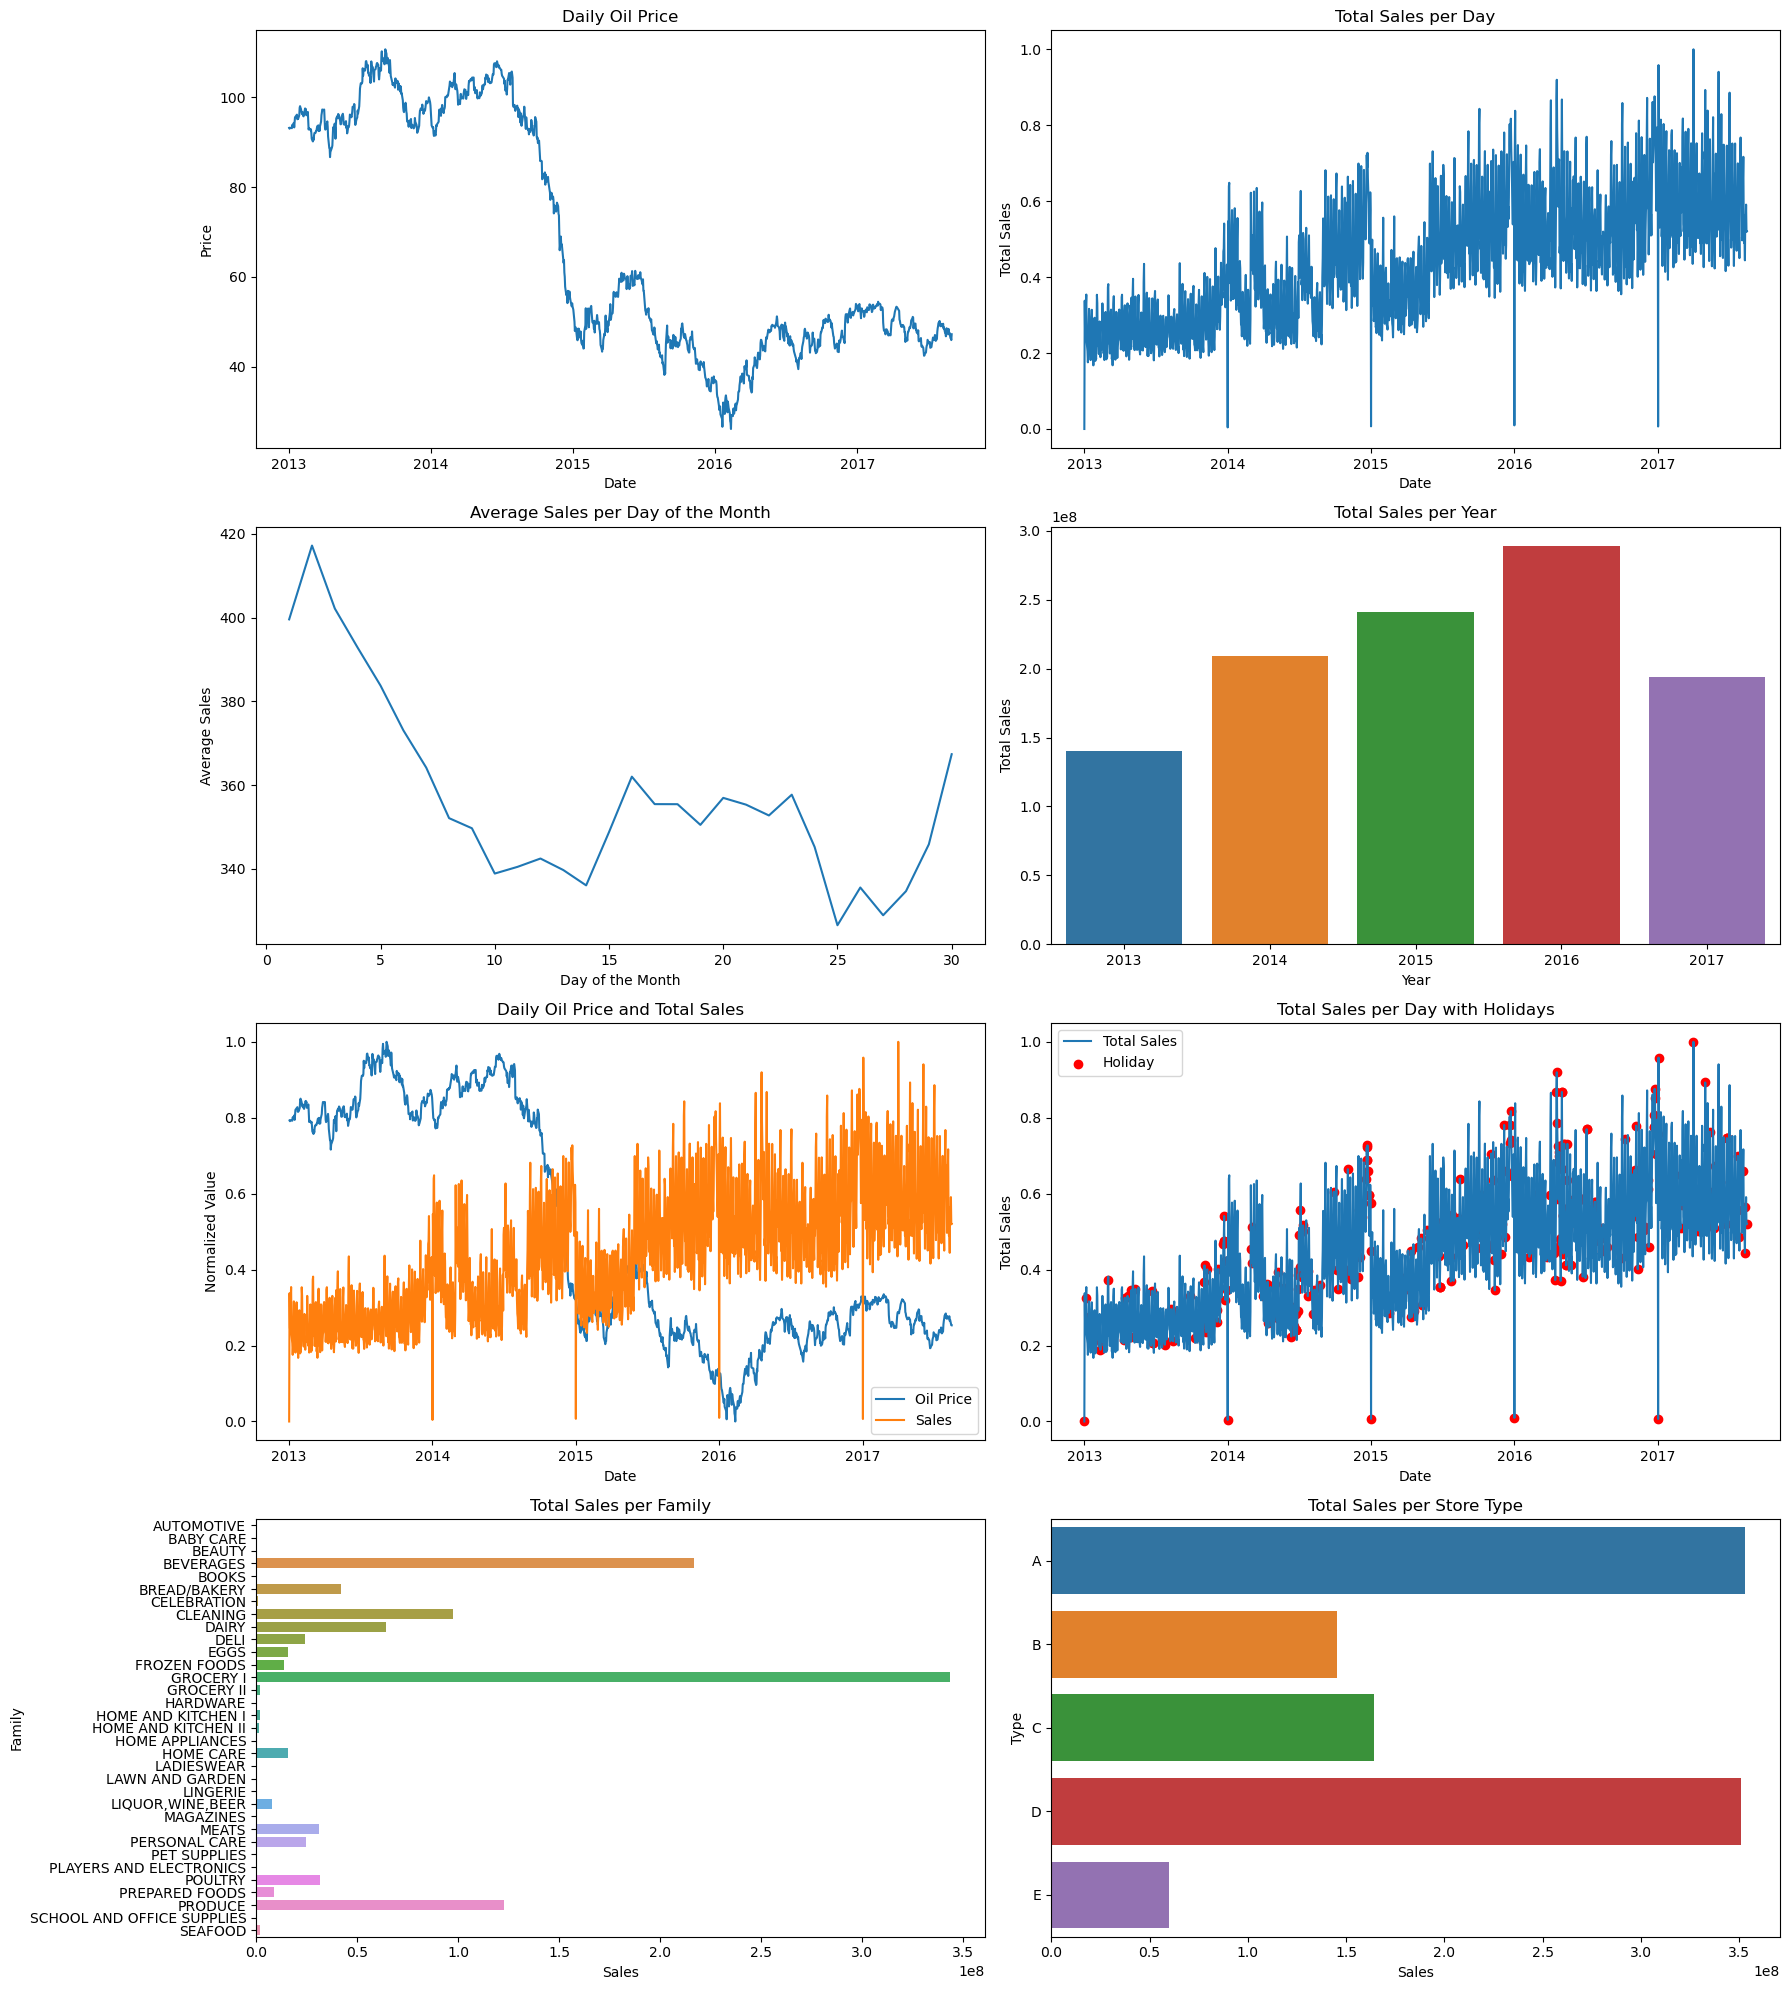

In [19]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


total_sales = train_data[["sales", "date"]].groupby("date").sum().reset_index()
daily_sales_per_month = train_data.groupby(train_data["date"].dt.day)["sales"].mean().reset_index()
daily_sales_per_month.drop(index=30, axis=0, inplace=True)
yearly_sales = train_data.groupby(train_data["date"].dt.year)["sales"].sum().reset_index()

total_sales = total_sales.merge(oil_data, on="date", how="left", suffixes=('', '_oil'))
scaler = MinMaxScaler()
total_sales["dcoilwtico"] = scaler.fit_transform(total_sales[["dcoilwtico"]])
total_sales["sales"] = scaler.fit_transform(total_sales[["sales"]])

# Créer la figure et les sous-graphiques
fig, axes = plt.subplots(4, 2, figsize=(18, 20))

# Graphique 1: Prix du pétrole quotidien
sns.lineplot(ax=axes[0, 0], x=oil_data["date"], y=oil_data["dcoilwtico"])
axes[0, 0].set(xlabel="Date", ylabel="Price", title="Daily Oil Price")

# Graphique 2: Ventes totales par jour
sns.lineplot(ax=axes[0, 1], x=total_sales["date"], y=total_sales["sales"])
axes[0, 1].set(xlabel="Date", ylabel="Total Sales", title="Total Sales per Day")

# Graphique 3: Ventes moyennes par jour du mois
sns.lineplot(ax=axes[1, 0], x=daily_sales_per_month["date"], y=daily_sales_per_month["sales"])
axes[1, 0].set(xlabel="Day of the Month", ylabel="Average Sales", title="Average Sales per Day of the Month")

# Graphique 4: Ventes totales par année
sns.barplot(ax=axes[1, 1], x=yearly_sales["date"], y=yearly_sales["sales"])
axes[1, 1].set(xlabel="Year", ylabel="Total Sales", title="Total Sales per Year")

# Graphique 5: Prix du pétrole et ventes totales normalisés
sns.lineplot(ax=axes[2, 0], x=total_sales["date"], y=total_sales["dcoilwtico"], label="Oil Price")
sns.lineplot(ax=axes[2, 0], x=total_sales["date"], y=total_sales["sales"], label="Sales")
axes[2, 0].set(xlabel="Date", ylabel="Normalized Value", title="Daily Oil Price and Total Sales")
axes[2, 0].legend()

# Graphique 6: Ventes totales par jour avec jours fériés
holidays = holidays_data.merge(total_sales, on="date", how="left")
sns.lineplot(ax=axes[2, 1], data=total_sales, x="date", y="sales", label="Total Sales")
axes[2, 1].scatter(holidays["date"], holidays["sales"], color='red', label="Holiday", marker='o')
axes[2, 1].set(xlabel="Date", ylabel="Total Sales", title="Total Sales per Day with Holidays")
axes[2, 1].legend()

#Graphique 7: Sales par famille
sales_per_family = train_data.groupby("family")["sales"].sum().reset_index()
sns.barplot(x=sales_per_family["sales"], y=sales_per_family["family"], ax=axes[3, 0])
axes[3, 0].set(xlabel="Sales", ylabel="Family", title="Total Sales per Family")

# Graphique 8: Ventes par type de magasin
sales_per_type = train_data.merge(stores_data, on="store_nbr", how="left").groupby("type")["sales"].sum().reset_index()
sns.barplot(x=sales_per_type["sales"], y=sales_per_type["type"], ax=axes[3, 1])
axes[3, 1].set(xlabel="Sales", ylabel="Type", title="Total Sales per Store Type")




# Ajuster la mise en page
plt.tight_layout()
plt.show()

## **Lag Analysis**

In [20]:
train_data['log_sales'] = np.log1p(train_data['sales'])
log_target_column = 'log_sales'

In [ ]:
lag_values = range(1, 366)
correlations = {}


for lag_value in lag_values:
    lag_column = f'{log_target_column}_lag_{lag_value}'
    if lag_column not in train_data.columns:
        train_data.loc[:, lag_column] = train_data[log_target_column].shift(lag_value)
    correlation = train_data[[log_target_column, lag_column]].corr().loc[log_target_column, lag_column]
    correlations[lag_value] = correlation


correlation_df = pd.DataFrame(list(correlations.items()), columns=['Lag', 'Correlation'])


sorted_correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

top_n = 10  
print(f'Top {top_n} lags les plus corrélés:')
sorted_correlation_df.head(top_n)

/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_9014/3719122353.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data.loc[:, lag_column] = train_data[log_target_column].shift(lag_value)
/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_9014/3719122353.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data.loc[:, lag_column] = train_data[log_target_column].shift(lag_value)
/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_9014/3719122353.py:8: PerformanceWarning: DataFrame is highly f

Top 10 lags les plus corrélés:


,Lag,Correlation
32,33,0.824213
362,363,0.810805
65,66,0.793658
263,264,0.788757
230,231,0.779355
98,99,0.770194
296,297,0.766928
329,330,0.765155
131,132,0.762072
164,165,0.757744


<p style="color:lightblue">Calcul du lag pour voir quels sont les jours qui ont le plus d'influence sur le présent</p>

In [72]:
from statsmodels.tsa.stattools import pacf

# Compute Partial Autocorrelation Function (PACF)
pacf_values = pacf(train_data[log_target_column], nlags=365)

# Create a sorted DataFrame for top correlated lags
top_n = 10  # Number of top lags to display
sorted_pacf_df = (
    pd.DataFrame({'Lag': range(1, 366), 'PACF': pacf_values[1:]})  # Exclude lag 0
    .assign(Abs_PACF=lambda df: df['PACF'].abs())  # Add column for absolute PACF
    .sort_values(by='Abs_PACF', ascending=False)  # Sort by absolute PACF
)

# Display top correlated lags
print(f'Top {top_n} most correlated lags (PACF):')
print(sorted_pacf_df.head(top_n))


Top 10 most correlated lags (PACF):
    Lag      PACF  Abs_PACF
32   33  0.747169  0.747169
33   34 -0.370413  0.370413
34   35 -0.306183  0.306183
65   66  0.282504  0.282504
11   12  0.267486  0.267486
1     2  0.251305  0.251305
12   13  0.239909  0.239909
26   27  0.219321  0.219321
0     1  0.189177  0.189177
98   99  0.183164  0.183164


# Preprocessing

In [21]:
#Creating a function to prepare the data merging the dataframes and adding features (lag, trend, seasonality)
def prepare_data(df):
    
    X = df.copy()
    
    X = X.merge(stores_data, on = "store_nbr", how = "left")
    
    # Join the daily oil prices with the training data
    X = X.merge( oil_data, on = "date", how = "left")
    
    # Add a feature for the day of the month
    X["day"] = X["date"].dt.day
    
    # Add a feature for the name of the day  (e.g., 'Monday', 'Tuesday')
    X["day_name"] = X["date"].dt.day_name()
    
    # Add a boolean feature to know if it's the end of the month
    X["is_month_end"] = X["date"].dt.is_month_end
    
    # Add a boolean feature to know if it's the middle of the month
    X["is_month_middle"] = X["date"].dt.day == 15

    

    # Add trend features ( Order 2 )
    date = X["date"].unique()
    trend = np.arange(date.shape[0])
    trend_features = pd.DataFrame({
        "date" : date,
        "trend" : trend,
        "trend_squared":np.square(trend)
        }    
    )
    trend_features["date"] = pd.to_datetime(trend_features["date"])
    X = X.merge( trend_features ,on="date",how="left")
    # Add yearly seasonality (Order 1)
    X["sin_day_of_year"] = np.sin(2 * np.pi * X["date"].dt.dayofyear / 365)
    X["cos_day_of_year"] = np.cos(2 * np.pi * X["date"].dt.dayofyear / 365)

    # Add monthly seasonality (Order 1)
    X["sin_month"] = np.sin(2 * np.pi * X["date"].dt.month / 12)
    X["cos_month"] = np.cos(2 * np.pi * X["date"].dt.month / 12)

    # Add seasonality around 33 days
    X["sin_33_days"] = np.sin(2 * np.pi * X["date"].dt.dayofyear / 33)
    X["cos_33_days"] = np.cos(2 * np.pi * X["date"].dt.dayofyear / 33)


    # Add lag features
    X["sales_lag_33"] = X.groupby(["family","store_nbr" ])["sales"].shift(33)


    X=X.drop ( ["date" , "id"] ,axis=1)

    return X 


In [22]:
# We wont't be using all the data for training 
# We will just use the data starting form 2015-7-1 because the trend repeat itself before that date

# Training set indicies
training_start = train_data[train_data["date"] == pd.to_datetime("2015-7-1")].index[0]
training_end = train_data[train_data["date"] == pd.to_datetime("2017-8-1")].index[0] #The last day of the training and testing set

validation_start = train_data[train_data["date"] == pd.to_datetime("2017-8-2")].index[0] #The first day of the validation

# Printing the results
print("Training Start: ", training_start)
print("Training End: ", training_end)
print("Validation Start: ", validation_start)

Training Start:  1619838
Training End:  2974158
Validation Start:  2975940


In [23]:
X_train = prepare_data(train_data)
X_train.head()

,store_nbr,family,sales,onpromotion,log_sales,city,state,type,cluster,dcoilwtico,...,is_month_middle,trend,trend_squared,sin_day_of_year,cos_day_of_year,sin_month,cos_month,sin_33_days,cos_33_days,sales_lag_33
0,1,AUTOMOTIVE,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,0,0,0.017213,0.999852,0.5,0.866025,0.189251,0.981929,NaN
1,1,BABY CARE,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,0,0,0.017213,0.999852,0.5,0.866025,0.189251,0.981929,NaN
2,1,BEAUTY,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,0,0,0.017213,0.999852,0.5,0.866025,0.189251,0.981929,NaN
3,1,BEVERAGES,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,0,0,0.017213,0.999852,0.5,0.866025,0.189251,0.981929,NaN
4,1,BOOKS,0.0,0,0.0,Quito,Pichincha,D,13,NaN,...,False,0,0,0.017213,0.999852,0.5,0.866025,0.189251,0.981929,NaN


In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Categorical features that need preprocessing
cat_features=["family","city","state","type","day_name"]
# Continuous features that need preprocessing
cont_features = ["dcoilwtico"] 

# pipeline for continuous features
cont_pipeline=make_pipeline(
    SimpleImputer(strategy = "mean"),
    StandardScaler()
)

# Pipeline for categorical features
cat_pipeline=make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown="ignore",sparse_output=False)
)

# Combine the pipelines using ColumnTransformer
preprocessor=ColumnTransformer(
    transformers=[
        ("cont",cont_pipeline,cont_features),
        ("cat",cat_pipeline,cat_features)
        
    ],
    remainder='passthrough'
)

model=xgb.XGBRegressor( objective = "reg:tweedie", random_state = 0  ) 

# Combine the preprocessor and model into a single pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model',model)
])


In [25]:
# Drop the sales column from the dataframe
y_train = X_train["sales"]
X_train = X_train.drop("sales" , axis = 1 )

X_train = X_train[training_start : training_end :]
y_train = y_train[training_start : training_end :]

X_train.head()

,store_nbr,family,onpromotion,log_sales,city,state,type,cluster,dcoilwtico,day,...,is_month_middle,trend,trend_squared,sin_day_of_year,cos_day_of_year,sin_month,cos_month,sin_33_days,cos_33_days,sales_lag_33
1619838,1,AUTOMOTIVE,0,1.791759,Quito,Pichincha,D,13,56.94,1,...,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,-0.095056,-0.995472,2.0
1619839,1,BABY CARE,0,0.000000,Quito,Pichincha,D,13,56.94,1,...,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,-0.095056,-0.995472,0.0
1619840,1,BEAUTY,1,1.791759,Quito,Pichincha,D,13,56.94,1,...,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,-0.095056,-0.995472,0.0
1619841,1,BEVERAGES,2,7.878155,Quito,Pichincha,D,13,56.94,1,...,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,-0.095056,-0.995472,2194.0
1619842,1,BOOKS,0,0.000000,Quito,Pichincha,D,13,56.94,1,...,False,909,826281,0.008607,-0.999963,-0.5,-0.866025,-0.095056,-0.995472,0.0


In [26]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
#Fit the pipeline to the training data
final_pipeline.fit(X_train,y_train)
predictions = final_pipeline.predict(X_train)

print("Training Error: ")
print("RMSLE:", np.sqrt(mean_squared_log_error(predictions, y_train)))
print("MAE:",mean_absolute_error(predictions, y_train ))
print("R2:",r2_score(predictions, y_train ))

Training Error: 
RMSLE: 0.010670198571293662
MAE: 9.607398000476444
R2: 0.9963181172246648


# Model training

In [27]:

y_validation = train_data["sales"][validation_start : : ].copy()

train_data["sales"][validation_start : : ] = np.nan


X_validation =prepare_data(train_data)
X_validation = X_validation [validation_start : :]

X_validation = X_validation.drop("sales" ,axis = 1 )

/var/folders/24/pnnls1cd57zc3t91xz4kyxyc0000gn/T/ipykernel_21400/2306730903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["sales"][validation_start : : ] = np.nan


In [28]:
valid_predictions = final_pipeline.predict(X_validation)
print("Validation Error: ")
print("RMSLE:", np.sqrt(mean_squared_log_error( valid_predictions, y_validation ) ))
print("MAE:", mean_absolute_error( valid_predictions, y_validation ) )
print("R2:", r2_score( valid_predictions, y_validation ) )

Validation Error: 
RMSLE: 0.01221027017050947
MAE: 11.281897997433509
R2: 0.9944826920588623


In [37]:
import optuna

def objective(trial):

    params = {
       "model__n_estimators": trial.suggest_int("model__n_estimators", 50, 1000),  
         "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.3, log=True),  
         "model__min_child_weight": trial.suggest_int("model__min_child_weight", 1, 6),  
         "model__max_depth": trial.suggest_int("model__max_depth", 3, 15),  
         "model__subsample": trial.suggest_float("model__subsample", 0.5, 1.0, step=0.1),  
         "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.5, 1.0, step=0.1),  
         "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-3, 10.0, log=True),  
         "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-3, 10.0, log=True)  
         }

    # Create a new pipeline with the parameters
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', xgb.XGBRegressor(objective="reg:tweedie", random_state=0, **params))
    ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_validation)
    rmsle = np.sqrt(mean_squared_log_error(y_validation, preds))
    return rmsle


study = optuna.create_study( direction="minimize", sampler=optuna.samplers.TPESampler(seed = 0) )
study.optimize(objective, n_trials=100 , n_jobs=2)
best_parameters =  study.best_trial.params
final_pipeline.set_params(**best_parameters)

[I 2024-12-13 09:01:05,914] A new study created in memory with name: no-name-42d8cbba-035e-4f12-bc1c-dd208e0d236a
[09:01:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

[09:01:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

[I 2024-12-13 09:02:01,414] Trial 1 finished with value: 0.013497908031801948 and parameters: {'model__n_estimators': 180, 'model__learning_rate': 0.01479569790511928, 'model__min_child_weight': 6, 'model__max_depth': 4, 'model__subsample': 0.5, 'model__colsample_bytree': 0.9, 'model__reg_lambda': 0.035162616

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dcoilwtico']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.01479569790511928, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=6, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=180, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

In [29]:
best_parameters = best_parameters = {
    'model__n_estimators': 987,
    'model__learning_rate': 0.03974568823588938,
    'model__min_child_weight': 5,
    'model__max_depth': 14,
    'model__subsample': 0.7,
    'model__colsample_bytree': 0.5,
    'model__reg_lambda': 0.3882731379185479,
    'model__reg_alpha': 0.009556952677129724
}
final_pipeline.set_params(**best_parameters)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dcoilwtico']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03974568823588938, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=14,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=987, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

In [30]:
# Retrain the model on both the training and validation sets

# Reread the training data to make sure it was not changed 
train_data =pd.read_csv("content_time/train.csv")
train_data["date"] = pd.to_datetime(train_data["date"])

X_all = prepare_data( train_data  )
X_all = X_all[training_start : :]
y_all = X_all["sales"]
X_all = X_all.drop("sales" , axis = 1)


final_pipeline.fit( X_all , y_all )

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cont',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['dcoilwtico']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03974568823588938, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=14,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=987, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

In [31]:
valid_predictions = final_pipeline.predict(X_validation)
print("Validation Error: ")
print("RMSLE:",np.sqrt(mean_squared_log_error(valid_predictions, y_validation )))
print("MAE:",mean_absolute_error(valid_predictions, y_validation ))
print("R2:",r2_score(valid_predictions, y_validation ))

Validation Error: 
RMSLE: 0.264028073468176
MAE: 23.705118278706315
R2: 0.9970235894280673


# Submission

In [32]:
test_size=test_data.shape[0]
# Concatenate the test data with the training data (We need the training data for  lag features)
test_data = pd.concat([train_data , test_data])
# Convert the date column to datetime type
test_data["date"]= pd.to_datetime(test_data["date"])

In [33]:
# Save the IDs column for the test data ( Needed for the submission) 
ids = test_data["id"].tail(test_size)

test_data=prepare_data(test_data)

test_data = test_data.tail(test_size)
test_data.drop(["sales" ] , axis =1 , inplace =True)

In [34]:
test_predictions=final_pipeline.predict(test_data)

# Put the test predictions in a CSV file
test_predictions=test_predictions.reshape(-1)
output = pd.DataFrame({'id': ids, 'sales': test_predictions})
output.to_csv('submission.csv', index=False)

output.head()

,id,sales
0,3000888,4.590976
1,3000889,0.000228
2,3000890,6.986631
3,3000891,2356.057129
4,3000892,0.008347
